In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import matplotlib

from skglm import GeneralizedLinearEstimator
from skglm.penalties import WeightedL1
from skglm.datafits import Quadratic

matplotlib.rcParams.update({'font.size': 16})

In [2]:
company_table = pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100')[4]
stock_list = company_table['Ticker'].to_list()

In [3]:
start_time = '2017-01-01'
end_time = '2022-12-31'

stock_data = []
for idx in stock_list:
    temp_data = yf.download(idx, start=start_time, end=end_time)
    data_ = pd.DataFrame()
    data_[idx] = temp_data['Adj Close']
    stock_data.append(data_)

stock_data = pd.concat(stock_data, axis=1)
stock_data = stock_data.reset_index()
stock_data['Date'] = pd.to_datetime(stock_data['Date'], format="%d-%m-%Y").dt.date
stock_data = stock_data.set_index('Date')

stock_data = stock_data.fillna(method='ffill')
stock_data = stock_data.fillna(method='bfill')

stock_pct = stock_data.pct_change()[1:]
stock_idx = stock_pct.index 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
nasdaq_data =  yf.download('^NDX', start=start_time, end=end_time)['Adj Close']

nasdaq_data = nasdaq_data.fillna(method='ffill')
nasdaq_data = nasdaq_data.fillna(method='bfill')

nasdaq_pct = nasdaq_data.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed


In [8]:
train_widnow = 100
test_window = 30

X = stock_pct.values * 100
y = nasdaq_pct.values * 100

T = X.shape[0]
y_est_dict = {}

y_gt_list = []
y_est_list = []

S = (1/T) * X.T.dot(X)
eigen_vals, eigen_vects = np.linalg.eig(S)
eigen_vals = eigen_vals / np.sum(eigen_vals)

alphas = [i for i in np.arange(0, 110, 10)]

for idx, alpha in enumerate(alphas):
    alpha = round(alpha, 3)
    model = GeneralizedLinearEstimator(Quadratic(), WeightedL1(alpha=alpha, weights=eigen_vals, positive=True))
    
    for i in range(train_widnow, T - test_window, test_window):
        X_train = X[i - train_widnow:i, :]
        y_train = y[i - train_widnow:i]

        X_test = X[i:i + test_window, :]
        y_test = y[i:i + test_window]

        model.fit(X_train, y_train)
        w_est = model.coef_
        w_est = w_est / np.sum(w_est)
        y_est = X_test.dot(w_est)

        y_est_list.append(y_est)
        y_gt_list.append(y_test)
        
    y_res = np.concatenate(y_est_list)
    y_gt = np.concatenate(y_gt_list)
    
    y_est_dict[alpha] = y_res
    
    y_est_list = [] 
    y_gt_list = []

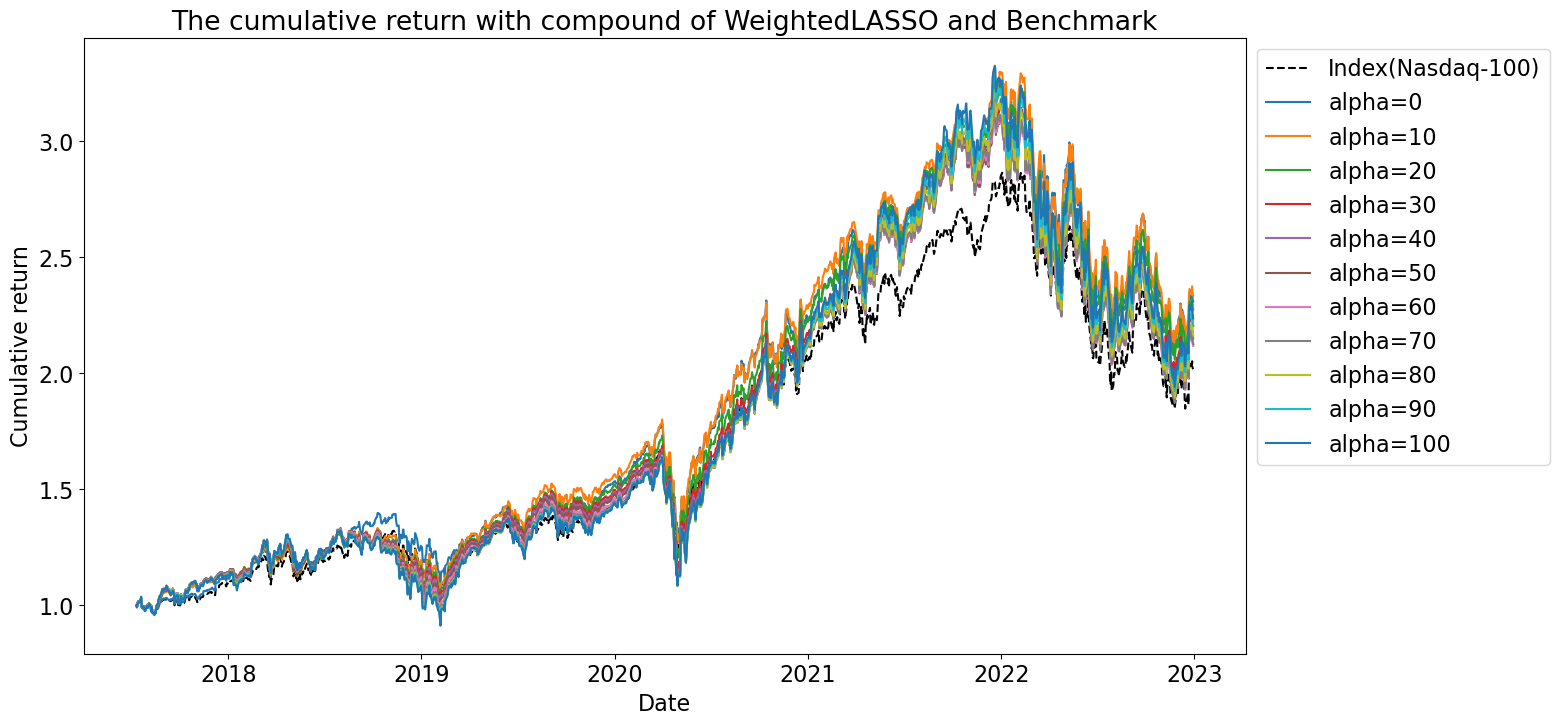

In [9]:
plt.figure(figsize=(15, 8))
indx = stock_idx[train_widnow + test_window-1:]
plt.plot(indx, np.cumprod((1 + y_gt/100)), '--', color='black', label = 'Index(Nasdaq-100)')

for key, val in y_est_dict.items():
    plt.plot(indx, np.cumprod((1+val/100)), label='alpha=' + str(key))

plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of WeightedLASSO and Benchmark")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left')
plt.show()

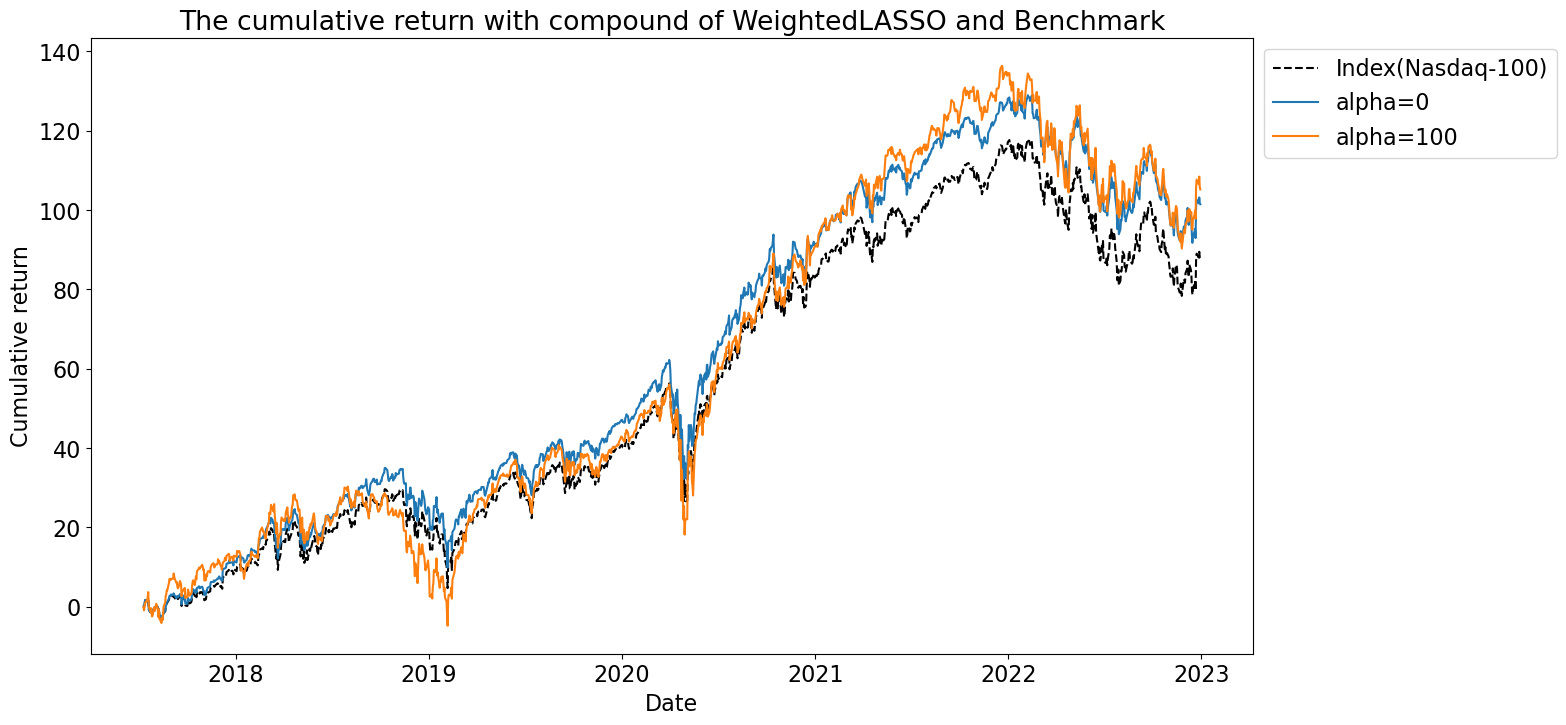

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(indx, np.cumsum(y_gt), '--', color='black', label = 'Index(Nasdaq-100)')
plt.plot(indx, np.cumsum(y_est_dict[0]), label='alpha=' + str(0))
plt.plot(indx, np.cumsum(y_est_dict[100]), label='alpha=' + str(100))
plt.ylabel("Cumulative return")
plt.xlabel("Date")
plt.title("The cumulative return with compound of WeightedLASSO and Benchmark")
plt.legend(bbox_to_anchor=(1.00, 1.0), loc='upper left')
plt.show()